# Modelado

Importar librerías y lectura de datos

In [87]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import itertools

data = pd.read_csv('Datos_Madrid_tratados.csv')

## Estudio de las variables

In [88]:
data.columns

Index(['ID', 'Precio', 'Tipo', 'N Habitaciones', 'm2', 'Comentario', 'Zona',
       'Subzona', 'Info', 'Mas detalles', 'Comentario_lower',
       'Mas detalles_lower', 'Info_lower', 'Planta', 'Cantidad de plantas',
       'Piscina', 'Ascensor', 'Garaje', 'N banos', 'Latitud', 'Longitud',
       'Precio_m2'],
      dtype='object')

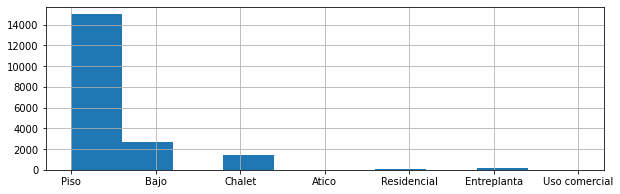

In [89]:
data['Tipo'].hist(figsize=(10, 3))
plt.show()

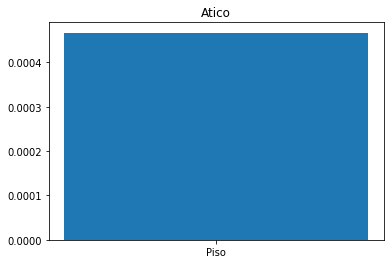

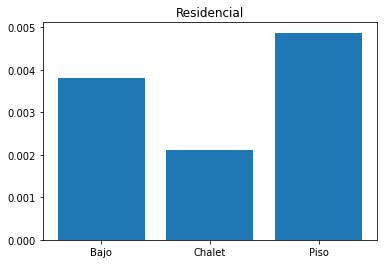

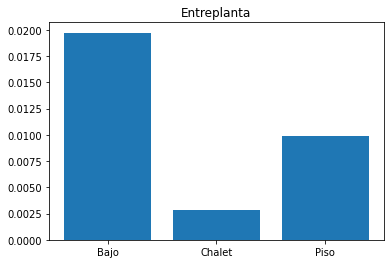

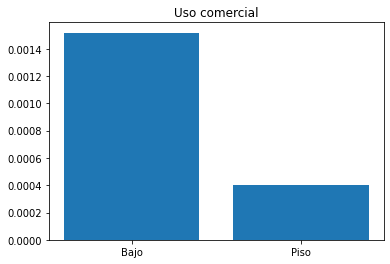

In [90]:
list_num = ['Precio_m2', 'Precio', 'N Habitaciones', 'm2', 'Planta', 'Cantidad de plantas', 'Piscina', 'Ascensor', 'Garaje', 'N banos', 'Latitud', 'Longitud']
from sklearn.neighbors import KNeighborsClassifier
X_train = data[data['Tipo'].isin(['Piso', 'Bajo', 'Chalet'])]
Y_train = data[~data['Tipo'].isin(['Piso', 'Bajo', 'Chalet'])].copy()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train[list_num], X_train['Tipo'])
Y_train["enlace"] = neigh.predict(Y_train[list_num])
cant_Tipo = X_train['Tipo'].value_counts()
Y_train["cant_Tipo"] = Y_train["enlace"].apply(lambda x : 1/cant_Tipo[x])
for item in list(Y_train["Tipo"].unique()):
    df_tmp = Y_train[Y_train['Tipo'] == item][['enlace', 'cant_Tipo']].groupby('enlace').sum()
    plt.bar(df_tmp.index, df_tmp['cant_Tipo'])
    plt.title(item)
    plt.show()
data.loc[data["Tipo"].isin(["Atico", "Residencial"]), "Tipo"] = "Piso"
data.loc[data["Tipo"].isin(["Entreplanta", "Uso comercial"]), "Tipo"] = "Bajo"

Esta respuesta da pie a pensar que todos deberían caer dentro de piso, menos entreplanta y uso comercial.
Lo que se plantea en ponderar la cantidad de tipos para el KN, ya que sería injusto mirar aproximaciones, cuando por ejemplo 'pisos' es mucho más denso que el resto.

In [91]:
def plot_data_points(data, x, y, label, size = None):
    fig, ax = plt.subplots(figsize=(10, 7))
    list_labels = list(data[label].unique())
    for item in list_labels:
        data_item = data[data[label] == item]
        if size is None :
            size_tmp = 10
        else:
            size_tmp = data_item[size]*3
        ax.scatter(data_item[x], data_item[y], s = size_tmp, label=item)
    if size is not None:
        title= f'{label} en función de {size}'
    else:
        title= label
    ax.set_title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    ax.legend(list_labels, loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

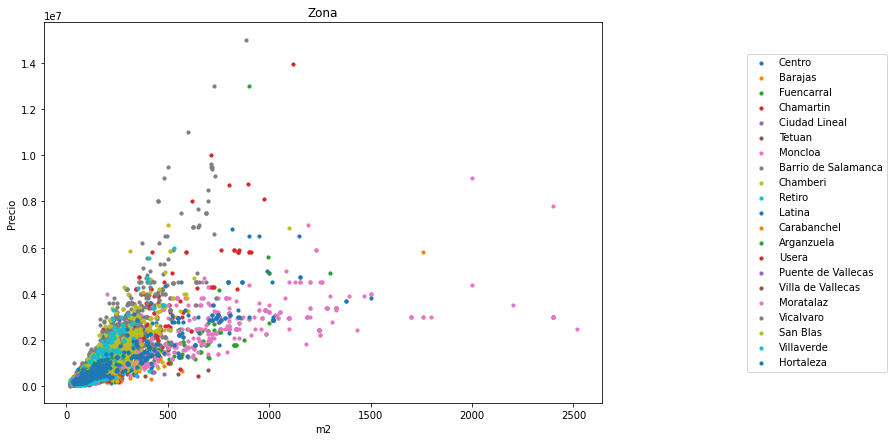

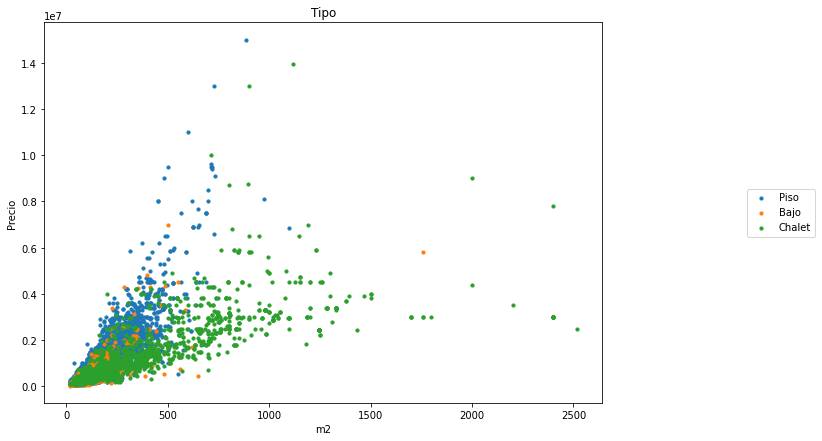

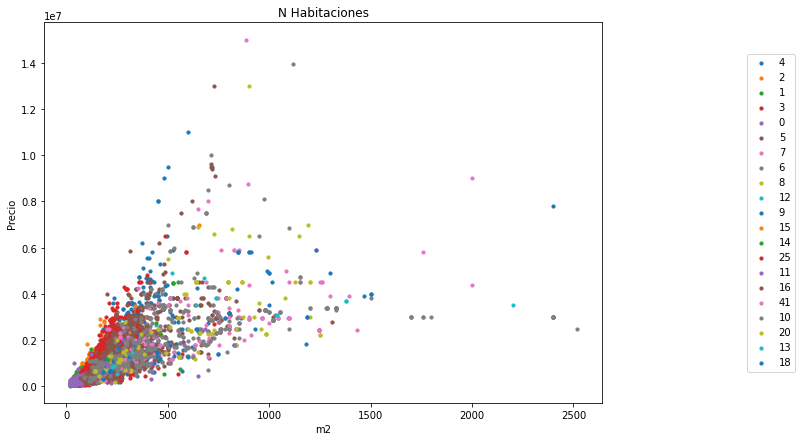

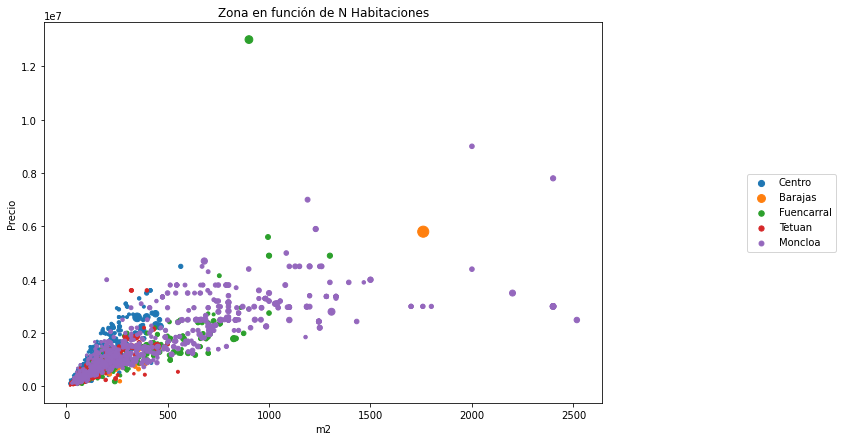

In [92]:
plot_data_points(data, "m2", "Precio", "Zona")
plot_data_points(data, "m2", "Precio", "Tipo")
plot_data_points(data, "m2", "Precio", "N Habitaciones")
data_tmp = data[data["Zona"].isin(data[data["N Habitaciones"] > 15]["Zona"].unique())]
plot_data_points(data_tmp, "m2", "Precio", "Zona", "N Habitaciones")

In [93]:
data.dtypes

ID                       int64
Precio                   int64
Tipo                    object
N Habitaciones           int64
m2                       int64
Comentario              object
Zona                    object
Subzona                 object
Info                    object
Mas detalles            object
Comentario_lower        object
Mas detalles_lower      object
Info_lower              object
Planta                   int64
Cantidad de plantas      int64
Piscina                  int64
Ascensor                 int64
Garaje                   int64
N banos                  int64
Latitud                float64
Longitud               float64
Precio_m2              float64
dtype: object

Se transforma la columna tipo por one hot encoder

In [94]:
dummy_type = pd.get_dummies(data['Tipo'])
home_type_columns = dummy_type.columns
data = pd.concat([data, dummy_type], axis=1)

Se trabaja sólo con las columnas numéricas

In [95]:
data = data.select_dtypes(exclude=object).drop('ID', axis = 1)

## Primera nomalización sobe los datos
SE guardan los valores por los que se guía la normalización en factors_values

In [96]:
# Guardaremos un conjunto de validación para aplicar los factores de normalización al entrenamiento y luego normalizar
# la validación con los factores obtenidos
data_train = data.sample(frac=0.8,random_state=0)
data_valid = data.drop(data_train.index)


In [97]:
# Factores iniciales para aplicar la normalización
def factors_values_initial(data):
    factors_values = data.agg(['max', 'min']).transpose()
    factors_values['denom_factor'] = factors_values['max'] - factors_values['min']
    factors_values['weight'] = 1
    return factors_values

In [98]:
def normalize_column(df: pd.Series, factors_values):    
    return (df-factors_values['min'])/factors_values['denom_factor'] * factors_values['weight']

def normalize(df: pd.DataFrame, factors_values):
    for column in df:
        df[column] = normalize_column(df[column], factors_values.loc[column])
    return df

In [99]:
factors_values = factors_values_initial(data)
data_nr = normalize(data, factors_values)

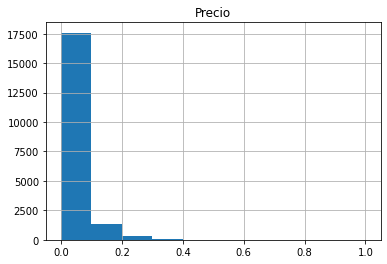

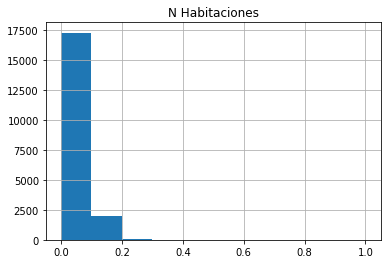

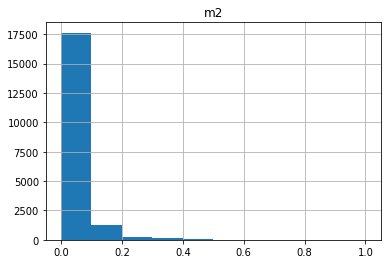

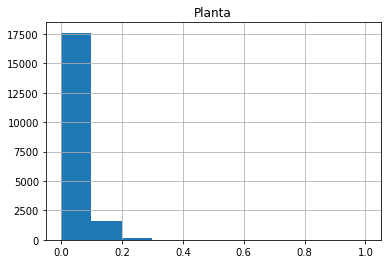

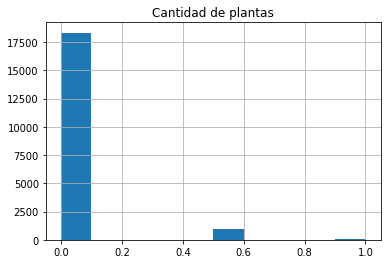

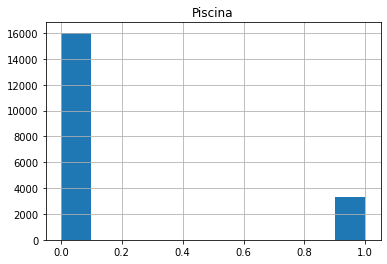

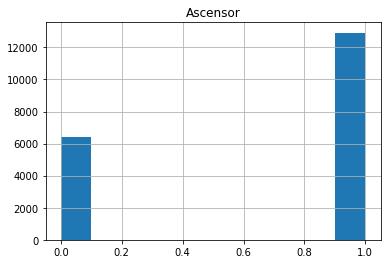

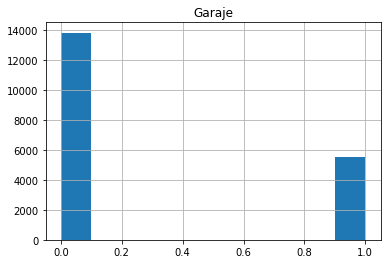

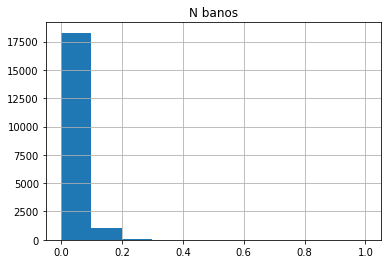

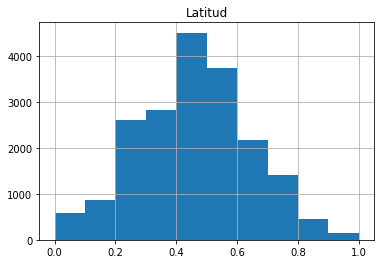

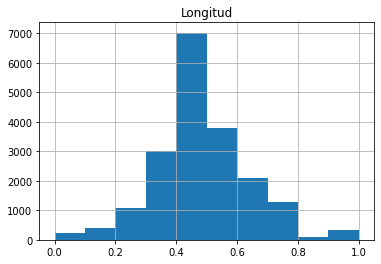

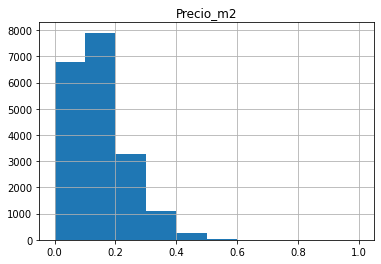

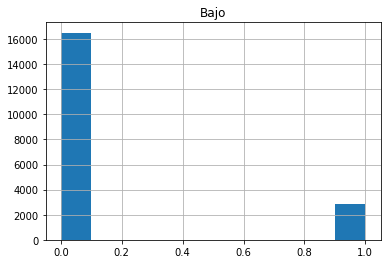

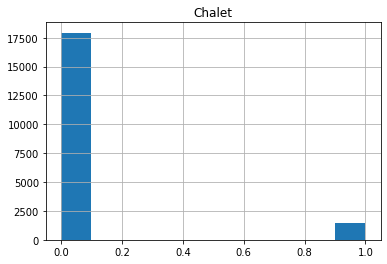

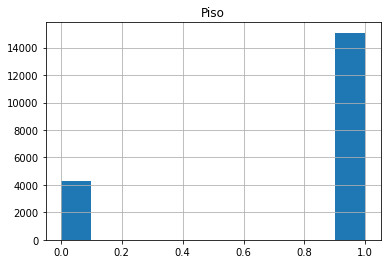

In [100]:
for column in data_nr.columns.tolist():
    data_nr[column].hist()
    plt.title(column)
    plt.show()
    

Fijas las variables features y predict

In [101]:
predict = 'Precio_m2'
fetures_exclude = ['Precio'] + [predict]
features = [column for column in data_nr if column not in fetures_exclude]
features

['N Habitaciones',
 'm2',
 'Planta',
 'Cantidad de plantas',
 'Piscina',
 'Ascensor',
 'Garaje',
 'N banos',
 'Latitud',
 'Longitud',
 'Bajo',
 'Chalet',
 'Piso']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(data_nr[features], data_nr[predict], test_size = 0.3)

In [103]:
knn=KNeighborsRegressor(n_neighbors = 15, weights = 'distance', metric = 'euclidean', algorithm = 'brute')
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='brute', metric='euclidean', n_neighbors=15,
                    weights='distance')

In [104]:
y_pred_knn=knn.predict(X_test)

In [105]:
def check_solutions(X_train, X_test, knn, axis_x, axis_y):
    filter_test = X_test.sample(1)
    (filter_test_dictance, filter_test_neighbors) = knn.kneighbors(filter_test,return_distance=True)
    knn_pretty = X_train.iloc[filter_test_neighbors[0,:]]
    knn_dictance = filter_test_dictance[0,:]
    plt.scatter(knn_pretty[axis_x],knn_pretty[axis_y], s=(1 + knn_dictance * 5000), c='r', alpha=0.5)
    plt.scatter(filter_test[axis_x],filter_test[axis_y], c='b')
    plt.show()

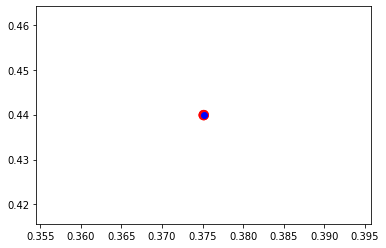

In [158]:
check_solutions(X_train, X_test, knn, 'Latitud', 'Longitud')

In [107]:
# Dato del que queremos predecir testigos
index_item = X_test.sample(1).index[0]
print(index_item)
(neighbor_distance, neighbor_positions) = knn.kneighbors(X_test.loc[[index_item]])
# Vecinos calculados
pd.concat([data_nr.loc[[index_item]], data_nr.loc[X_train.iloc[neighbor_positions[0]].index]], axis=0)

3976


,Precio,N Habitaciones,m2,Planta,Cantidad de plantas,Piscina,Ascensor,Garaje,N banos,Latitud,Longitud,Precio_m2,Bajo,Chalet,Piso
3976,0.155363,0.121951,0.131547,0.100000,0.0,1.0,1.0,1.0,0.097561,0.679171,0.524080,0.253440,0.0,0.0,1.0
4041,0.174741,0.121951,0.151140,0.100000,0.0,1.0,1.0,1.0,0.097561,0.679171,0.524080,0.248725,0.0,0.0,1.0
4033,0.170732,0.121951,0.140344,0.133333,0.0,1.0,1.0,1.0,0.097561,0.679171,0.524080,0.262346,0.0,0.0,1.0
3901,0.161377,0.097561,0.140344,0.133333,0.0,1.0,1.0,1.0,0.097561,0.679171,0.524080,0.246663,0.0,0.0,1.0
4021,0.198129,0.097561,0.117553,0.066667,0.0,1.0,1.0,1.0,0.121951,0.679171,0.524080,0.370066,0.0,0.0,1.0
3958,0.131306,0.121951,0.138745,0.050000,0.0,1.0,1.0,1.0,0.097561,0.679171,0.524080,0.198723,0.0,0.0,1.0
4004,0.144671,0.097561,0.113954,0.133333,0.0,1.0,1.0,1.0,0.121951,0.679171,0.524080,0.272696,0.0,0.0,1.0
3922,0.104577,0.097561,0.133946,0.050000,0.0,1.0,1.0,1.0,0.097561,0.679171,0.524080,0.159616,0.0,0.0,1.0
4052,0.104577,0.097561,0.133946,0.050000,0.0,1.0,1.0,1.0,0.097561,0.679171,0.524080,0.159616,0.0,0.0,1.0
3894,0.141330,0.097561,0.126349,0.050000,0.0,1.0,1.0,1.0,0.073171,0.679171,0.524080,0.238447,0.0,0.0,1.0


## Cálculo de puntuación en predicción de testigos, opción a realimentación de los clientes

In [108]:
# X es el dataset que queremos comprobar, data es el dataset donde comprobamos (el de entrenamiento y el nuevo concatenado)
def parse_tipo(conditions: dict):
    list_tipo = ['Bajo','Chalet','Piso']
    if "Tipo" in conditions.keys():
        for item in list_tipo:
            conditions[item] = conditions["Tipo"]
        conditions.pop("Tipo")
    return conditions

def calculate_score(row: pd.Series, data: pd.DataFrame, conditions: dict):
    return ((data[conditions.keys()] - row[conditions.keys()]).abs() < conditions.values()).all(axis=1).mean()


def testigos_correctos(x:pd.DataFrame, data:pd.DataFrame, model, conditions = {'Latitud':0.1,'Longitud':0.1,'m2':0.25}): 
    
    # Añadimos o restamos a 1 el valor de porcentaje elegido para establecer testigos válidos en esos campos
    
    neighbors = model.kneighbors(x, return_distance=False)
    
    x["neighbors"] = list(neighbors)
    x["score"] = x.apply(lambda row: calculate_score(row.drop("neighbors"), data.iloc[row["neighbors"]], conditions), axis=1)
    
    return np.mean(list(x["score"]))

In [109]:
conditions = {'Latitud':0.1,'Longitud':0.1,'m2':0.25}
score = testigos_correctos(X_test.iloc[:2].copy(), X_train, knn, conditions)


## Cálculo de parámetros

In [110]:
def total_factors_combinations(factor_list):
    list_tipo = ['Bajo','Chalet','Piso']
    total_factors_combinations = []
    factors_combinations = itertools.product(*factor_list.values())
    for factors_combination in factors_combinations:
        factors_item = {}
        for column, factor in zip(factor_list, factors_combination):
            if column == "Tipo":
                for column_tipo in list_tipo:
                    factors_item[column_tipo] = factor
            else:
                factors_item[column] = factor
        total_factors_combinations.append(factors_item)
    return total_factors_combinations

def ranking_factors_combinations(X_train, X_test, factor_list, conditions_sample, y_train):
    conditions_sample = parse_tipo(conditions_sample)
    factors_combinations = total_factors_combinations(factor_list)
    X_train_params = X_train.copy()
    X_test_params = X_test.copy()
    for factors_dict in factors_combinations:
        for column in factors_dict:
            X_train_params[column] = X_train[column]*factors_dict[column]
            X_test_params[column] = X_test[column]*factors_dict[column]
        knn = KNeighborsRegressor(n_neighbors = 15, weights = 'distance', metric = 'euclidean', algorithm = 'brute')
        knn.fit(X_train_params,y_train)
        score = testigos_correctos(X_test_params.copy(), X_train_params, knn, conditions_sample)
        factors_dict["score"] = score
    factors_combinations = sorted(factors_combinations, key=lambda item: item["score"], reverse=True)
    return factors_combinations

In [147]:
%%time
conditions_sample = {'Latitud':0.1,'Longitud':0.1,'m2':0.25}

factor_list = {}
factor_list['Latitud'] = [0.5,1,50]
factor_list['Longitud'] = [0.5,1,50]
factor_list['m2'] = [0.5,1,50]
factor_list['Tipo'] = [0.5,1,50]

combinations = ranking_factors_combinations(X_train, X_test, factor_list, conditions_sample)


# CrossValidation

In [111]:
def CV_function(data:pd.DataFrame, n:int, conditions:dict, features:list, predict:str, factor_list:dict):
    
    dict_params = {}
    
    for i in range(n):
        seed = 10*i
        # Conjunto de entrenamiento en la validación cruzada, variando la semilla garantizamos que varíe en cada iteración
        data_train = data.sample(frac=0.7,random_state=seed)
        # Conjunto de testeo en la validación cruzada
        data_test = data.drop(data_train.index)
        
        # Calculamos los factores de normalización en dicha iteración, solamente con los valores de entrenamiento (conocidos)
        factors_values = factors_values_initial(data_train)
        
        # Guardamos los factores de normalización en dicha iteración
        
        # Normalizamos los factores de normalización en dicha iteración (ambos datasets con los valores del entrenamiento)
        data_train_nr = normalize(data_train, factors_values)
        data_test_nr = normalize(data_test, factors_values)

        # Determinamos X e y con las variables pasadas en la función
        X_train = data_train_nr[features]
        y_train = data_train_nr[predict]
        X_test = data_test_nr[features]
        y_test = data_test_nr[predict]
        
        #knn=KNeighborsRegressor(n_neighbors = 15, weights = 'distance', metric = 'euclidean', algorithm = 'brute')
        #nn.fit(X_train,y_train)
        
        # Calculamos las combinaciones de parámetros y su score según las condiciones que se hayan determinado por el tasador
        combinations = ranking_factors_combinations(X_train, X_test, factor_list, conditions, y_train)
        
        # Guardamos los resultados de las combinaciones para dicha iteración
        print("Terminada iteración {} de {} totales en CV".format(i+1,n))
        
        dict_params[i] = {"seed": seed, "combinations": combinations, "normalizations" : factors_values}
        
    return dict_params

In [149]:
%%time
# Condiciones que determinamos para verificar un testigo como válido, el cálculo del score se basará en estas
conditions_sample = {'Latitud':0.1,'Longitud':0.1,'m2':0.015}

#~Parámetros para probar malla y ibtener los más adecuados
factor_list = {}
factor_list['Latitud'] = [0.1,0.4,1]
factor_list['Longitud'] = [0.1,0.4,1]
factor_list['m2'] = [0.1,0.4,1]
factor_list['Tipo'] = [0.1]

data = pd.read_csv('Datos_Madrid_tratados.csv')


data2 = data.copy()

# Conjunto que usaremos para obtener parámetros y comprobar resultados en CV
data2_train = data2.sample(frac=0.75, random_state = 0)


data2_train.loc[data2_train["Tipo"].isin(["Atico", "Residencial"]), "Tipo"] = "Piso"
data2_train.loc[data2_train["Tipo"].isin(["Entreplanta", "Uso comercial"]), "Tipo"] = "Bajo"

# Conjunto donde probaremos después los parámetros, dummificación y normalizaciones obtenidas en CV como conjunto de datos nuevos
data2_valid = data2.drop(data2_train.index)

# AHORA TRABAJAREMOS CON TRAIN PARA MANTENER VALID COMO CONJUNTO INDEPENDIENTE

dummy_type = pd.get_dummies(data2_train['Tipo'])
home_type_columns = dummy_type.columns
data2_train = pd.concat([data2_train, dummy_type], axis=1)

data2_train = data2_train.select_dtypes(exclude=object).drop('ID',axis=1)

predict = 'Precio_m2'
features_exclude = ['Precio'] + [predict]
features = [column for column in data2_train if column not in features_exclude]

cv_trial = CV_function(data=data2_train, n=2, conditions=conditions_sample, features=features, predict=predict, factor_list=factor_list)

Terminada iteración 1 de 2 totales en CV
Terminada iteración 2 de 2 totales en CV
CPU times: user 2min 3s, sys: 5.6 s, total: 2min 9s
Wall time: 2min 4s


In [150]:
factors_cv_mean = sum([cv_trial[item]["normalizations"] for item in cv_trial])/len(cv_trial)
factors_cv_mean

,max,min,denom_factor,weight
Precio,1.500000e+07,40000.000000,1.496000e+07,1.0
N Habitaciones,3.300000e+01,0.000000,3.300000e+01,1.0
m2,2.517000e+03,16.000000,2.501000e+03,1.0
Planta,6.000000e+01,0.000000,6.000000e+01,1.0
Cantidad de plantas,3.000000e+00,1.000000,2.000000e+00,1.0
Piscina,1.000000e+00,0.000000,1.000000e+00,1.0
Ascensor,1.000000e+00,0.000000,1.000000e+00,1.0
Garaje,1.000000e+00,0.000000,1.000000e+00,1.0
N banos,2.900000e+01,0.000000,2.900000e+01,1.0
Latitud,4.052050e+01,40.341900,1.786000e-01,1.0


In [151]:
#mean_score = np.mean(cv_trial[0])

factors_cv_mean = sum([cv_trial[item]["normalizations"] for item in cv_trial])/len(cv_trial)
factors_cv_mean

,max,min,denom_factor,weight
Precio,1.500000e+07,40000.000000,1.496000e+07,1.0
N Habitaciones,3.300000e+01,0.000000,3.300000e+01,1.0
m2,2.517000e+03,16.000000,2.501000e+03,1.0
Planta,6.000000e+01,0.000000,6.000000e+01,1.0
Cantidad de plantas,3.000000e+00,1.000000,2.000000e+00,1.0
Piscina,1.000000e+00,0.000000,1.000000e+00,1.0
Ascensor,1.000000e+00,0.000000,1.000000e+00,1.0
Garaje,1.000000e+00,0.000000,1.000000e+00,1.0
N banos,2.900000e+01,0.000000,2.900000e+01,1.0
Latitud,4.052050e+01,40.341900,1.786000e-01,1.0


In [152]:
# Mejores parámetros de media

best_params = sum([pd.Series(cv_trial[item]["combinations"][0]) for item in cv_trial])/len(cv_trial)
best_params

Bajo      0.100000
Chalet    0.100000
Piso      0.100000
score     0.701577
dtype: float64

In [153]:
## OBTENEMOS CONJUNTOS PARA ENTRENAR CON LA NORMALIZACIÓN MEDIA:

data2_train_final_nr = normalize(data2_train, factors_cv_mean)

X_train_final = data2_train_final_nr[features]
y_train_final = data2_train_final_nr[predict]

In [154]:
# EVALUAMOS EN VALIDACIÓN CON ESTE MODELO Y LOS PARÄMETROS MEDIOS OBTENIDOS

data2_valid.loc[data2_valid["Tipo"].isin(["Atico", "Residencial"]), "Tipo"] = "Piso"
data2_valid.loc[data2_valid["Tipo"].isin(["Entreplanta", "Uso comercial"]), "Tipo"] = "Bajo"

dummy_type = pd.get_dummies(data2_valid['Tipo'])
home_type_columns = dummy_type.columns
data2_valid = pd.concat([data2_valid, dummy_type], axis=1)

data2_valid = data2_valid.select_dtypes(exclude=object).drop('ID',axis=1)

data2_valid_nr = normalize(data2_valid,factors_cv_mean)

X_valid = data2_valid_nr[features]
y_valid = data2_valid_nr[predict]

# Aplicamos factores medios de las mejores puntuaciones
factor_list_final = {}
factor_list_final['Latitud'] = [0.1]
factor_list_final['Longitud'] = [0.1]
factor_list_final['m2'] = [0.1]
factor_list_final['Tipo'] = [0.85]

# Las condiciones las mismas que las de la validación:
conditions_sample = {'Latitud':0.1,'Longitud':0.1,'m2':0.015}

combinations_valid=ranking_factors_combinations(X_train_final, X_valid, factor_list_final, conditions_sample, y_train_final)

In [155]:
combinations_valid

[{'Latitud': 0.1,
  'Longitud': 0.1,
  'm2': 0.1,
  'Bajo': 0.85,
  'Chalet': 0.85,
  'Piso': 0.85,
  'score': 0.9923797712553396}]

In [156]:
# PRUEBA PARAMETROS MEDIOS
conditions = {'Latitud':0.1,'Longitud':0.1,'m2':0.015}
num_testigos_return = 15

data = pd.read_csv('Datos_Madrid_tratados.csv')

data2 = data.copy()


data2.loc[data2["Tipo"].isin(["Atico", "Residencial"]), "Tipo"] = "Piso"
data2.loc[data2["Tipo"].isin(["Entreplanta", "Uso comercial"]), "Tipo"] = "Bajo"
dummy_type = pd.get_dummies(data2['Tipo'])
home_type_columns = dummy_type.columns
data2 = pd.concat([data2, dummy_type], axis=1)

data2 = data2.select_dtypes(exclude=object).drop('ID',axis=1)

predict = 'Precio_m2'
features_exclude = ['Precio'] + [predict]
features = [column for column in data2 if column not in features_exclude]

data_train = data2.sample(frac=0.7,random_state=23)
data_test = data2.drop(data_train.index)
          
data_train_nr = normalize(data_train, factors_cv_mean)
data_test_nr = normalize(data_test, factors_cv_mean)

X_train = data_train_nr[features]
y_train = data_train_nr[predict]
X_test = data_test_nr[features]
y_test = data_test_nr[predict]
        
knn=KNeighborsRegressor(n_neighbors = num_testigos_return, weights = 'distance', metric = 'euclidean', algorithm = 'brute')
knn.fit(X_train,y_train)
        
score = testigos_correctos(X_test.copy(), X_train, knn, conditions)

In [157]:
score

0.7121447028423773

# No tener en cuenta

In [52]:
def apply_factors(X, factors):
    for column in factors:
        X[column] = X[column]*factors[column]
    return X

def calculate_incremental_by_column(row, X_train, column, factors, delta_incremental):
    closer = X_train.iloc[int(row["closer"])].to_numpy()
    farther = X_train.iloc[int(row["farther"])].to_numpy()
    np_row = row.drop(["closer", "farther"], axis = 0).to_numpy()
    factors_1 = factors.copy()
    factors_0 = factors.copy()
    factors_1[column] = max(factors_1[column] + delta_incremental, 10)
    factors_0[column] = min(factors_0[column] - delta_incremental, 0)
    result_closer = np_row - closer
    result_farther = np_row - farther
    result_closer_1 = sum(abs(result_closer*factors_1))
    result_closer_0 = sum(abs(result_closer*factors_0))
    result_closer = sum(abs(result_closer*factors))
    result_farther_1 = sum(abs(result_farther*factors_1))
    result_farther_0 = sum(abs(result_farther*factors_0))
    result_farther = sum(abs(result_farther*factors))
    result_1 = result_farther_1 - result_closer_1
    result_0 = result_farther_0 - result_closer_0
    result_orig = result_farther - result_closer
    if result_1 > result_orig:
        return 1
    elif result_0 > result_orig:
        return -1
    else:
        return 0

def calculate_incremental(X_train, relations, factors = None): 
    delta_incremental = 0.01
    if factors == None:
        factors = X_train.iloc[0].copy()
        factors[:] = 1
    for i in range(50):
        for column in X_train:
            factors_tmp = relations.apply(lambda row: calculate_incremental_by_column(row, X_train, column, factors, delta_incremental), axis = 1)
            factors[column] = factors[column] + factors_tmp.mode()[0]*delta_incremental
    return factors

def print_prediction(y, X_train, predictions):
    X_result = X_train.loc[predictions[y.index[0]][0]]
    X_result["cost"] = predictions[y.index[0]][1]
    return pd.concat([y, X_result], axis = 0)

class KNNNearest():
    
    def __init__(self, k = 15):
        #################################
        # Inicialización de parámetros.
        self._k = k
        #################################
    
    def fit(self, X, X_relation = None):
        #################################
        # X_relation is a dataframe with the parameters of 3 points by columns
        # Creación del modelo.
        self._X = X
        self._X_numpy = X.to_numpy()
        if X_relation is not None:
            self._factors = calculate_incremental(self._X, X_relation)
        else:
            self._factors = X_train.copy().iloc[0]
            self._factors[:] = 1
        self._factors_numpy = self._factors.to_numpy()
        #################################
    
    def predict(self, y):
        test_numpy = y.to_numpy()
        predictions = {}
        for row, index in zip(test_numpy, y.index):
            cost =  (abs(self._X_numpy - row)*self._factors_numpy).sum(axis=1)
            cost = np.array([self._X.index, cost])
            cost = cost[:, cost[1, :].argsort()][:, :self._k]
            predictions[index] = cost
        return predictions

In [117]:
knn_tmp= KNNNearest()

In [114]:
knn_tmp.fit(X_train)

In [33]:
test = X_train.iloc[:2]
predictions = knn_tmp.predict(test)

In [35]:
predictions

{8703: array([[8.70300000e+03, 9.43200000e+03, 8.67900000e+03, 8.65000000e+03,
         4.13300000e+03, 9.67300000e+03, 9.83500000e+03, 9.71000000e+03,
         8.61200000e+03, 4.36100000e+03, 1.49050000e+04, 9.56000000e+03,
         8.48100000e+03, 9.19000000e+03, 9.55600000e+03],
        [0.00000000e+00, 1.17791941e-02, 2.59896042e-02, 3.19872051e-02,
         4.14888766e-02, 4.65947507e-02, 4.68437051e-02, 5.25923517e-02,
         5.73237372e-02, 6.06562153e-02, 6.28332534e-02, 6.31348014e-02,
         6.41210183e-02, 6.45058124e-02, 6.79328821e-02]]),
 8148: array([[8.14800000e+03, 7.83300000e+03, 7.91300000e+03, 8.00600000e+03,
         8.19700000e+03, 8.24700000e+03, 7.90000000e+03, 8.28800000e+03,
         8.03100000e+03, 2.22400000e+03, 2.06200000e+03, 7.92800000e+03,
         9.53000000e+02, 8.01700000e+03, 8.15000000e+03],
        [0.00000000e+00, 7.99680128e-04, 7.99680128e-04, 7.99680128e-04,
         1.99920032e-03, 2.39904038e-03, 2.39904038e-03, 4.39824070e-03,
         

In [34]:
print_prediction(test.iloc[0:1], X_train, predictions)

,N Habitaciones,m2,Planta,Cantidad de plantas,Piscina,Ascensor,Garaje,N banos,Latitud,Longitud,Atico,Bajo,Chalet,Entreplanta,Piso,Residencial,Uso comercial,cost
8703.0,0.02439,0.049580,0.033333,0.0,0.0,1.0,0.0,0.02439,0.066667,0.904993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
8703.0,0.02439,0.049580,0.033333,0.0,0.0,1.0,0.0,0.02439,0.066667,0.904993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
9432.0,0.02439,0.044382,0.033333,0.0,0.0,1.0,0.0,0.02439,0.072229,0.903974,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.011779
8679.0,0.02439,0.023591,0.033333,0.0,0.0,1.0,0.0,0.02439,0.066667,0.904993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.025990
8650.0,0.02439,0.017593,0.033333,0.0,0.0,1.0,0.0,0.02439,0.066667,0.904993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.031987
4133.0,0.02439,0.029588,0.033333,0.0,0.0,1.0,0.0,0.02439,0.082833,0.910324,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.041489
9673.0,0.02439,0.057177,0.033333,0.0,0.0,1.0,0.0,0.04878,0.075630,0.910637,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.046595
9835.0,0.02439,0.044382,0.000000,0.0,0.0,1.0,0.0,0.02439,0.066507,0.913146,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.046844
9710.0,0.04878,0.035986,0.033333,0.0,0.0,1.0,0.0,0.02439,0.075630,0.910637,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.052592
8612.0,0.02439,0.025590,0.000000,0.0,0.0,1.0,0.0,0.02439,0.066667,0.904993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.057324


In [22]:
## Constructor del entrenamiento
relations = test.copy()
relations_orig = test.copy()
for i in range(5):
    closer_list = []
    farest_list = []
    for item in predict:
        closer_list.append(predict[item].index[i])
        farest_list.append(predict[item].index[i+1])
    relation_tmp = relations_orig.copy()
    relation_tmp.loc[:, "closer"] = closer_list
    relation_tmp.loc[:, "farest"] = farest_list
    if i > 0:
        relations = pd.concat([relations, relation_tmp], axis = 0, ignore_index = True)
    else:
        relations = relation_tmp.copy()

In [55]:
relations = {1: [10604,10366,4390]}
for i, item in enumerate(relations):
    list_sort = relations[item]
    entry_ref = X_train.loc[item].to_numpy()
    closer_list = np.array(list_sort[:-1]).reshape([2,1])
    farther_list = np.array(list_sort[1:]).reshape([2,1])
    entry_ref = np.tile(entry_ref, (len(list_sort)-1,1))
    entry_ref = np.append(entry_ref, closer_list, axis=1)
    entry_ref = np.append(entry_ref, farther_list, axis=1)
    if i > 0:
        np_relations = np.append(np_relations, entry_ref, axis = 0)
    else:
        np_relations = entry_ref.copy()
df_relations = pd.DataFrame(data=np_relations, columns=[list(X_train.columns) + ["closer", "farther"]])
df_relations[["closer", "farther"]] = df_relations[["closer", "farther"]].astype(int)
df_relations

,N Habitaciones,m2,Planta,Cantidad de plantas,Piscina,Ascensor,Garaje,N banos,Latitud,Longitud,Atico,Bajo,Chalet,Entreplanta,Piso,Residencial,Uso comercial,closer,farther
0,0.04878,0.026389,0.0,0.0,0.0,1.0,0.0,0.02439,0.067547,0.879204,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10604,10366
1,0.04878,0.026389,0.0,0.0,0.0,1.0,0.0,0.02439,0.067547,0.879204,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10366,4390


In [56]:
knn_tmp= KNNNearest()
knn_tmp.fit(X_train, df_relations)
test = X_train.iloc[:2]
predictions = knn_tmp.predict(test)
print_prediction(test.iloc[0:1], X_train, predictions)

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,N Habitaciones,m2,Planta,Cantidad de plantas,Piscina,Ascensor,Garaje,N banos,Latitud,Longitud,Atico,Bajo,Chalet,Entreplanta,Piso,Residencial,Uso comercial,cost
12041.0,0.048780,0.021591,0.050000,0.5,0.0,1.0,1.0,0.024390,0.054662,0.860469,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
12041.0,0.048780,0.021591,0.050000,0.5,0.0,1.0,1.0,0.024390,0.054662,0.860469,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
13641.0,0.048780,0.018792,0.050000,0.5,0.0,1.0,1.0,0.024390,0.020968,0.848554,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.027003
6173.0,0.048780,0.023591,0.050000,0.5,0.0,1.0,1.0,0.024390,0.100440,0.881790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.036549
13785.0,0.048780,0.023591,0.033333,0.5,0.0,1.0,1.0,0.048780,0.031293,0.861723,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.044172
6155.0,0.048780,0.027589,0.050000,0.5,0.0,1.0,1.0,0.048780,0.100440,0.881790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.054741
12573.0,0.000000,0.022391,0.050000,0.5,0.0,1.0,1.0,0.024390,0.024090,0.831152,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.055534
13100.0,0.073171,0.033986,0.050000,0.5,0.0,1.0,1.0,0.048780,0.031781,0.851689,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.058813
12574.0,0.000000,0.026789,0.050000,0.5,0.0,1.0,1.0,0.024390,0.024090,0.831152,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.062132
6117.0,0.024390,0.017593,0.050000,0.5,0.0,1.0,1.0,0.048780,0.100440,0.881790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.063938


In [141]:
print(knn_tmp._factors)

N Habitaciones         1.00
m2                     0.50
Planta                 0.50
Cantidad de plantas    0.50
Piscina                1.00
Ascensor               0.50
Garaje                 0.50
N banos                1.14
Latitud                1.50
Longitud               0.50
Atico                  1.00
Bajo                   1.00
Chalet                 1.00
Entreplanta            1.00
Piso                   1.00
Residencial            1.00
Uso comercial          1.00
Name: 8703, dtype: float64


In [132]:
knn_tmp._factors.mode()


0    1.0
dtype: float64

In [ ]:
relations